# About Dataset
The bank customer churn dataset is a commonly used dataset for predicting customer churn in the banking industry. It contains information on bank customers who either left the bank or continue to be a customer. The dataset includes the following attributes:

- Customer ID: A unique identifier for each customer
- Surname: The customer's surname or last name
- Credit Score: A numerical value representing the customer's credit score
- Geography: The country where the customer resides (France, Spain or Germany)
- Gender: The customer's gender (Male or Female)
- Age: The customer's age.
- Tenure: The number of years the customer has been with the bank
- Balance: The customer's account balance
- NumOfProducts: The number of bank products the customer uses (e.g., savings account, credit card)
- HasCrCard: Whether the customer has a credit card (1 = yes, 0 = no)
- IsActiveMember: Whether the customer is an active member (1 = yes, 0 = no)
- EstimatedSalary: The estimated salary of the customer
- Exited: Whether the customer has churned (1 = yes, 0 = no)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import warnings
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import plot_importance

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s4e1/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e1/test.csv')
sample = pd.read_csv('/kaggle/input/playground-series-s4e1/sample_submission.csv')

In [3]:
def col_to_drop(df):
    df.drop(columns = ['id', 'CustomerId', 'Surname'], inplace =True)
    return df


def encode_categorical(df):
    categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
    encoded_df = df.copy()
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=FutureWarning)
        for column in categorical_columns:
            one_hot_encoder = OneHotEncoder(sparse=False, drop='first')
            encoded_values = one_hot_encoder.fit_transform(df[[column]])
            new_columns = [f"{column}_{value}" for value in one_hot_encoder.get_feature_names_out([column])]
            encoded_df[new_columns] = encoded_values
            encoded_df = encoded_df.drop(column, axis=1)

    return encoded_df

train = col_to_drop(train)
test = col_to_drop(test)

# Data Description

In [4]:
train.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


## Observations:
- The dataset contains customers with a diverse range of credit scores, ages, tenure, and balances.
- The majority of customers have a credit card and are not active members.
- The churn rate is around 21.16%, indicating that there is some imbalance in the target variable.

# Target Column Distribution

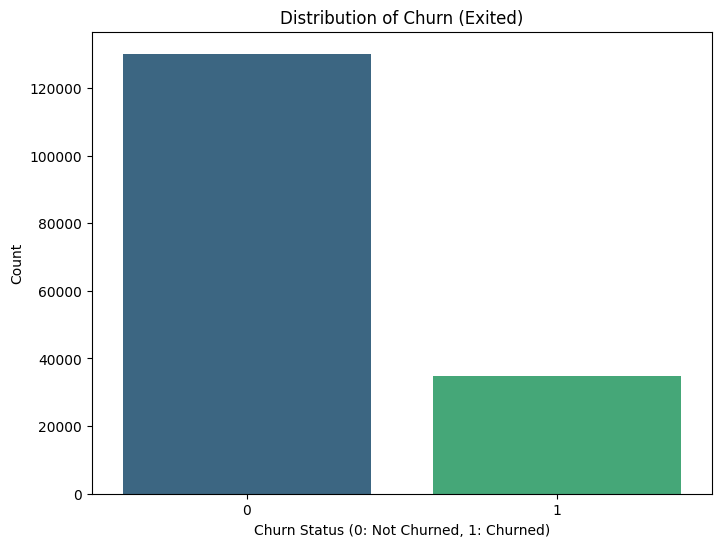

Churn Distribution:
Exited
0    130113
1     34921
Name: count, dtype: int64


In [5]:
exit_counts = train['Exited'].value_counts()
plt.figure(figsize=(8, 6))
sns.countplot(x='Exited', data=train, palette='viridis')
plt.title('Distribution of Churn (Exited)')
plt.xlabel('Churn Status (0: Not Churned, 1: Churned)')
plt.ylabel('Count')
plt.show()
print("Churn Distribution:")
print(exit_counts)

# Numerical Distribution

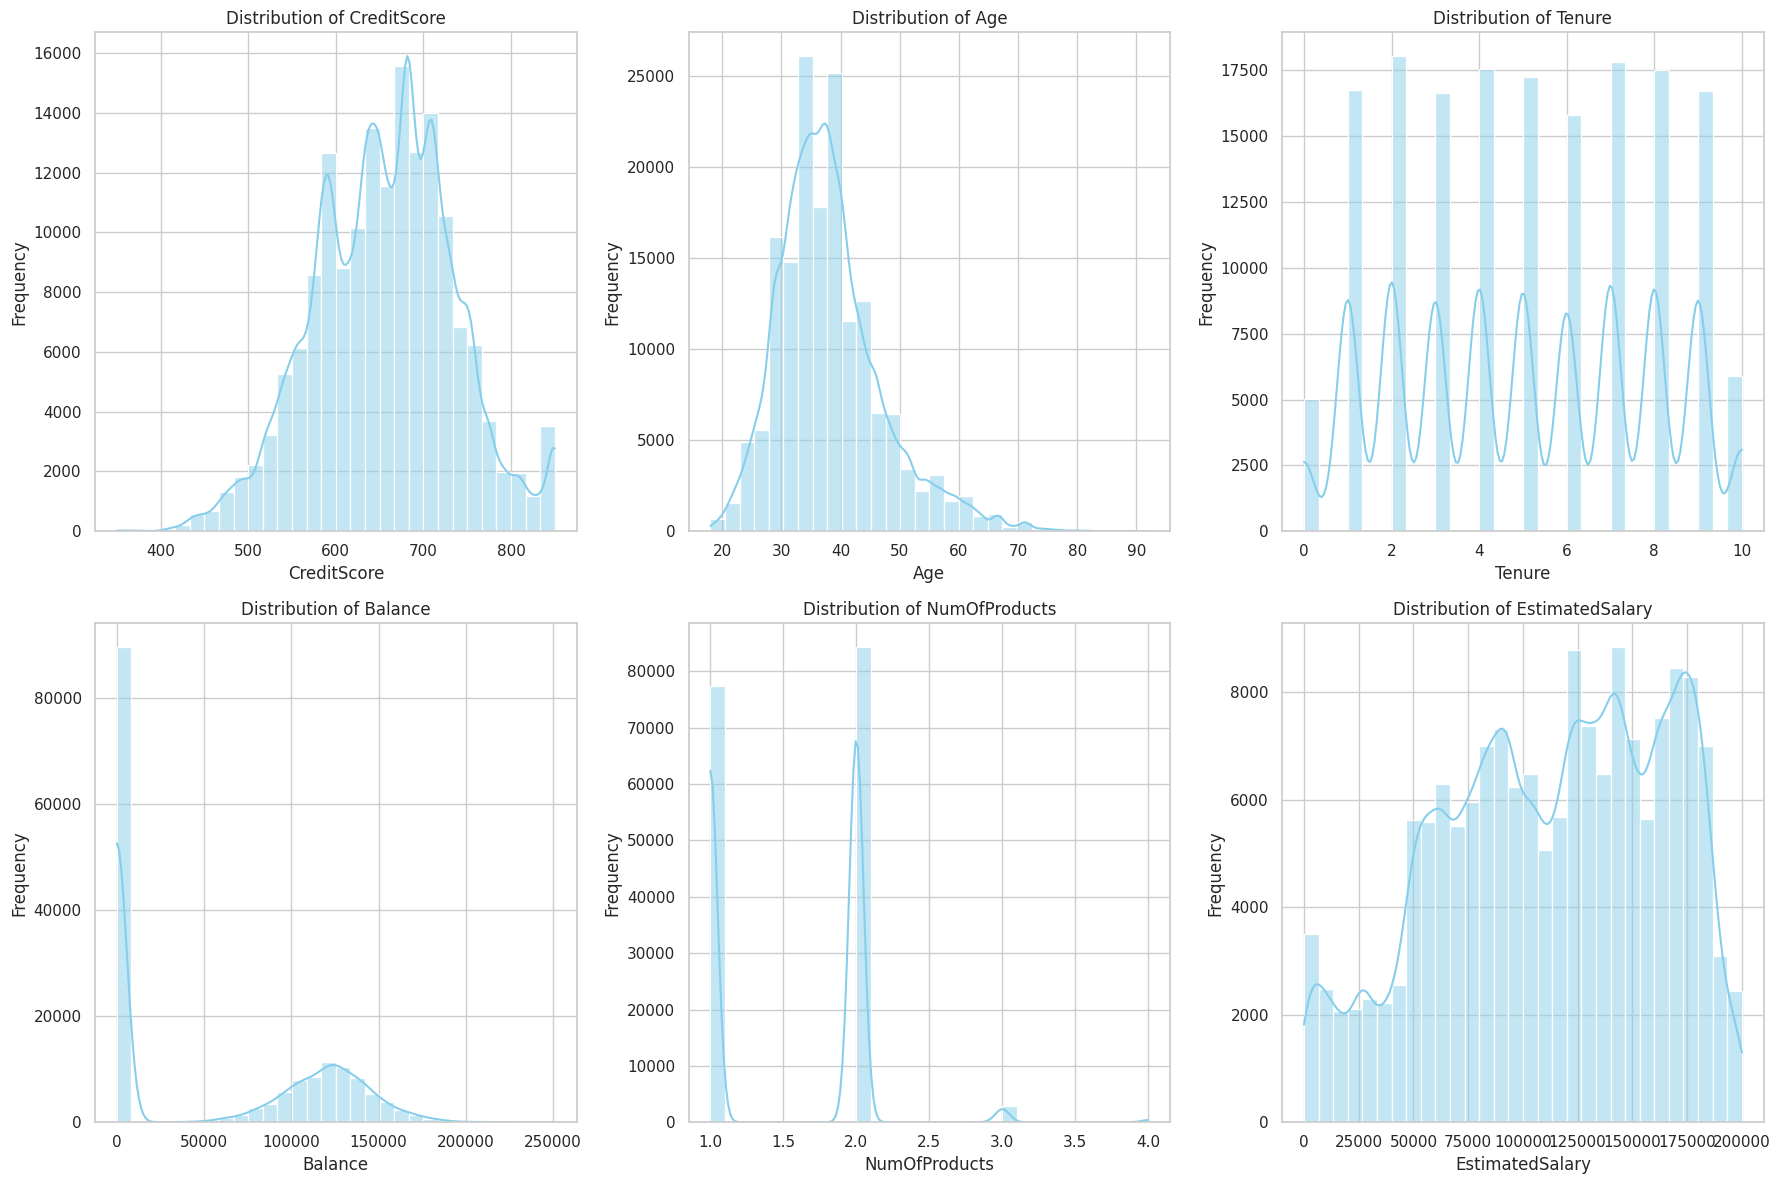

In [6]:
sns.set(style="whitegrid")
numerical_columns = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
axes = axes.flatten()
for i, column in enumerate(numerical_columns):
    sns.histplot(train[column], kde=True, bins=30, color='skyblue', ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

# Categorical Distribution

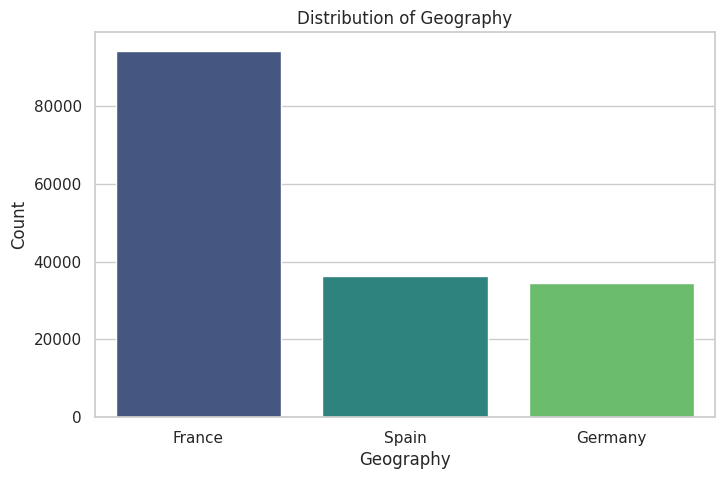

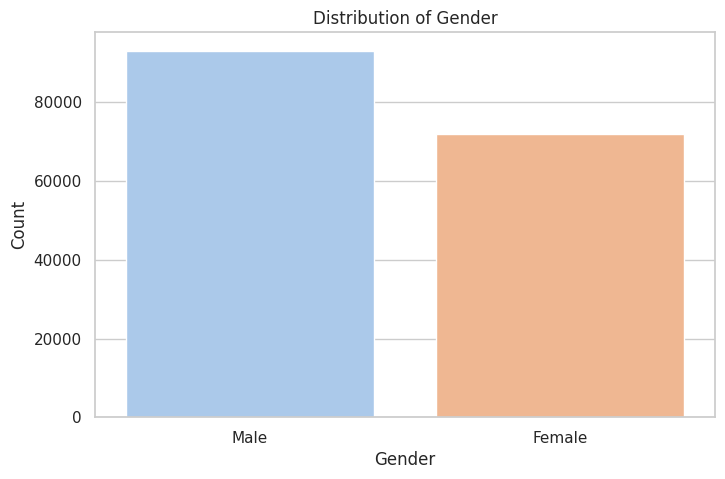

In [7]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Geography', data=train, palette='viridis')
plt.title('Distribution of Geography')
plt.xlabel('Geography')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(8, 5))
sns.countplot(x='Gender', data=train, palette='pastel')
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

# Churn Analysis

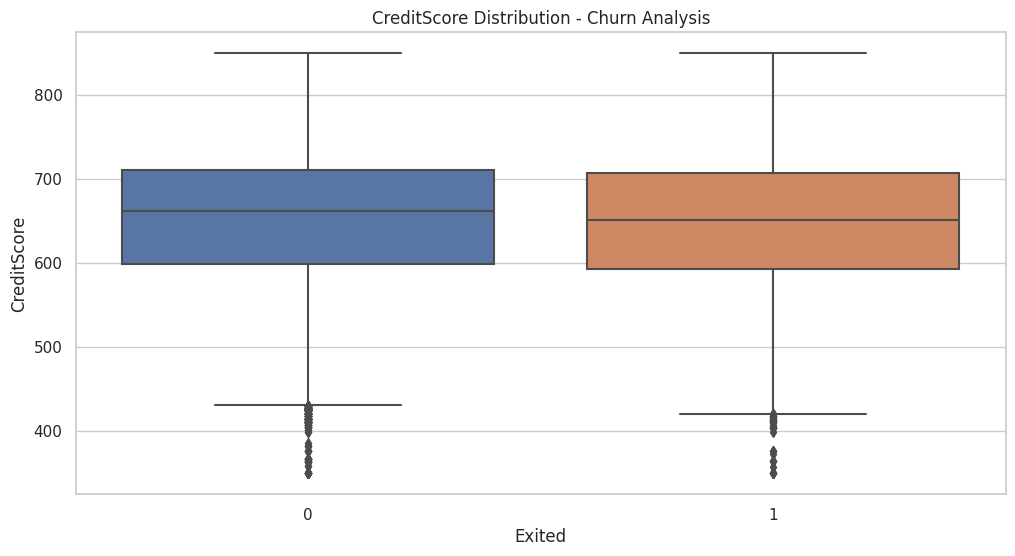

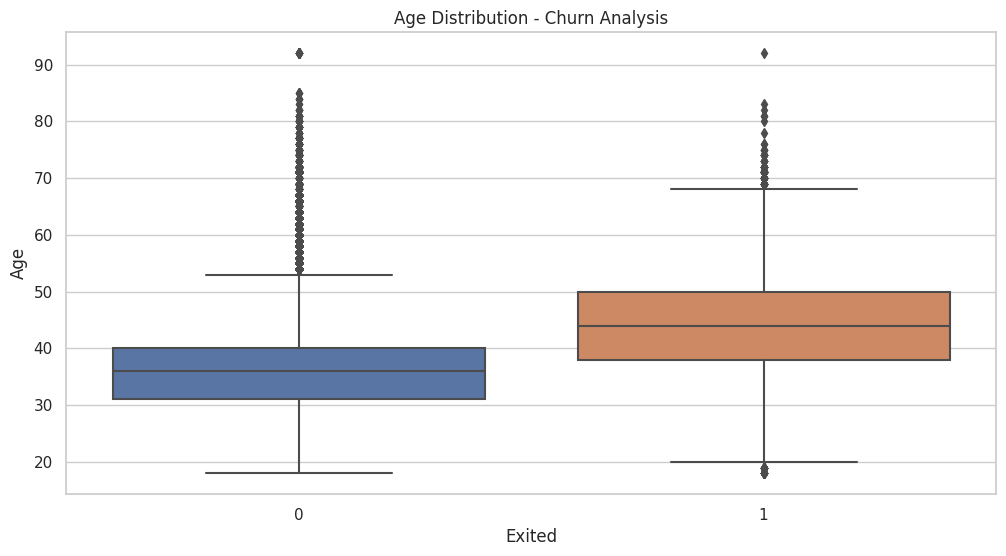

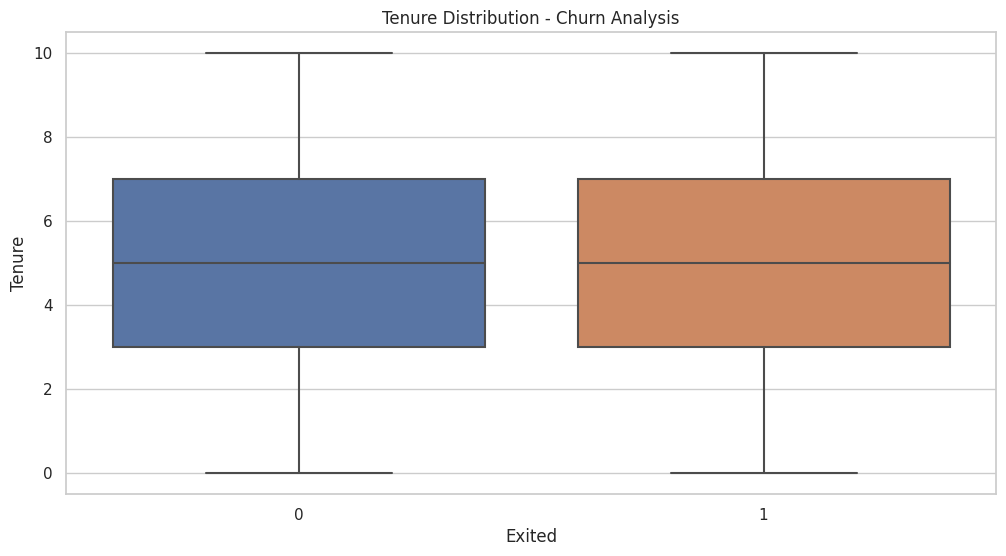

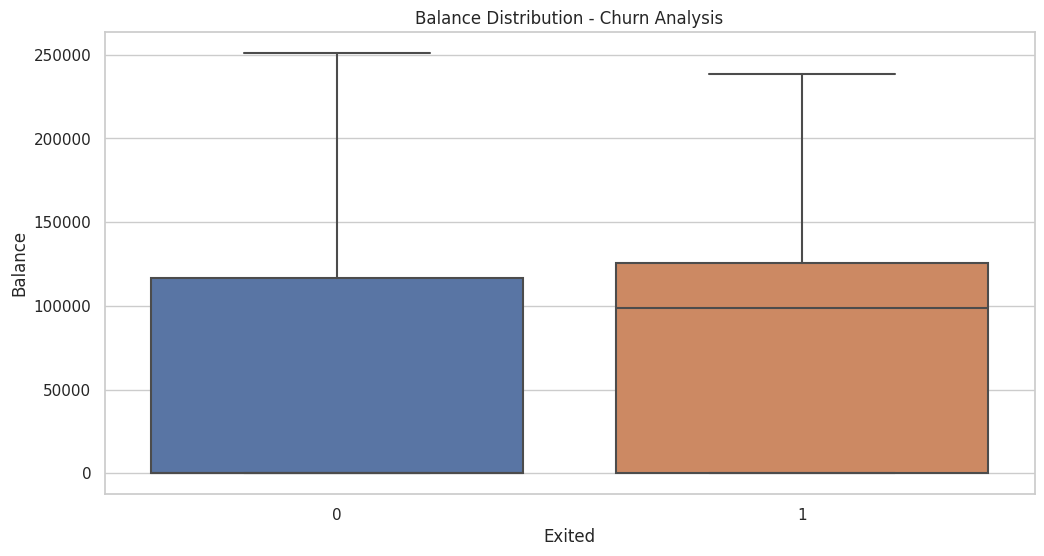

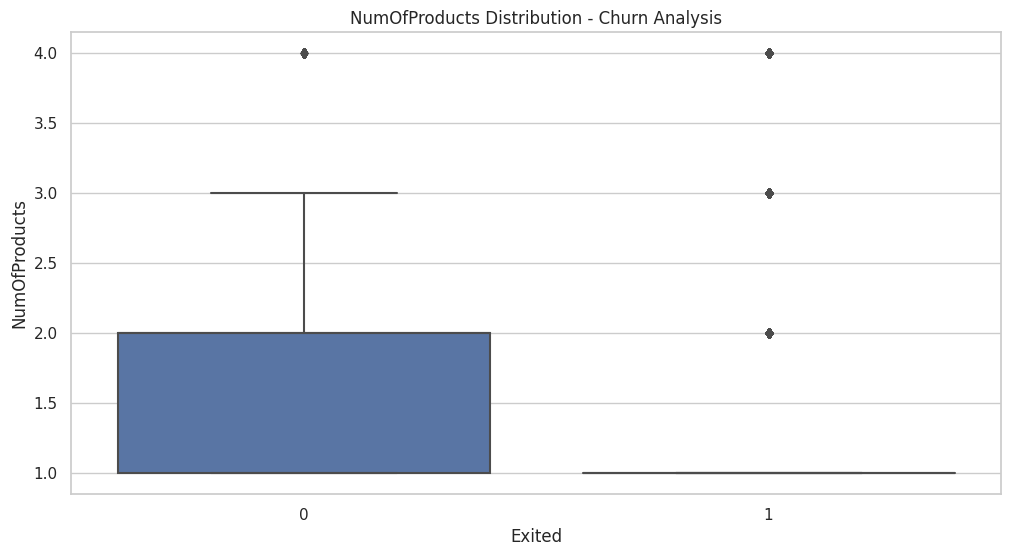

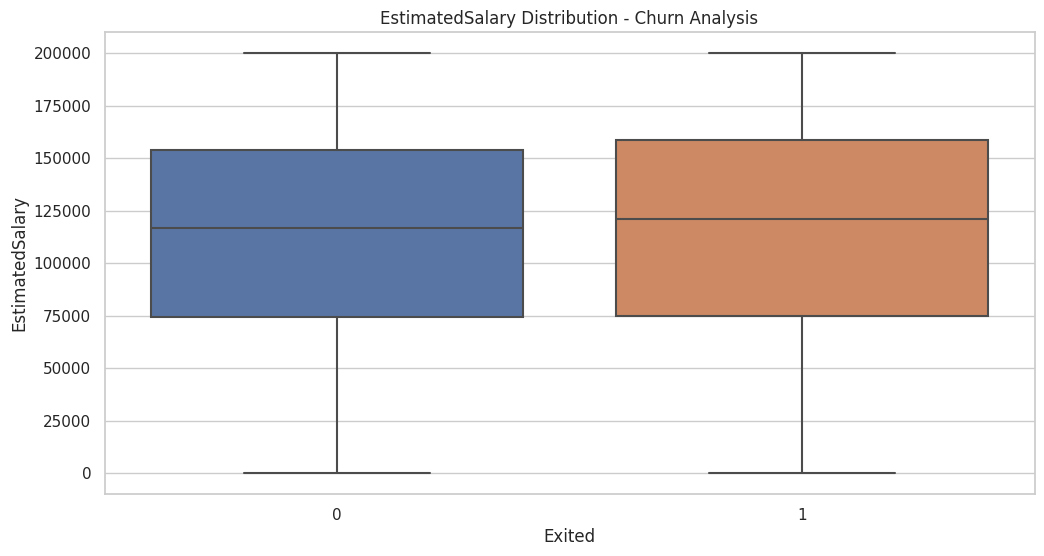

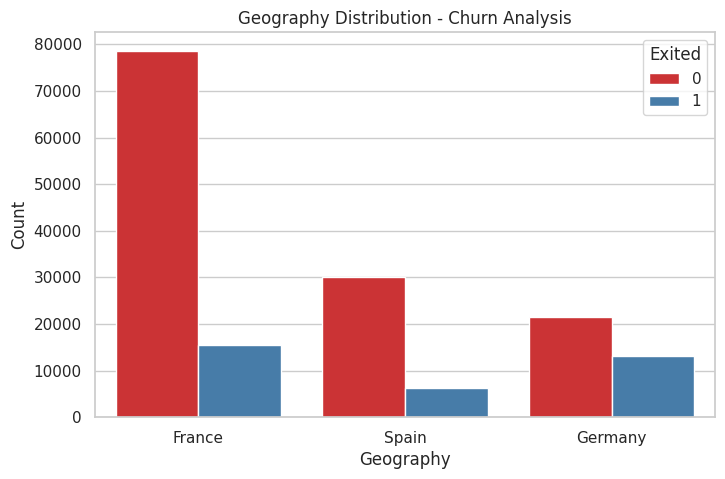

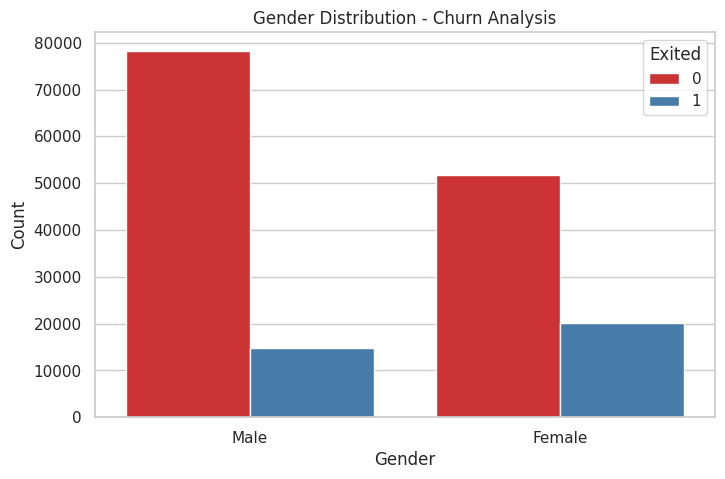

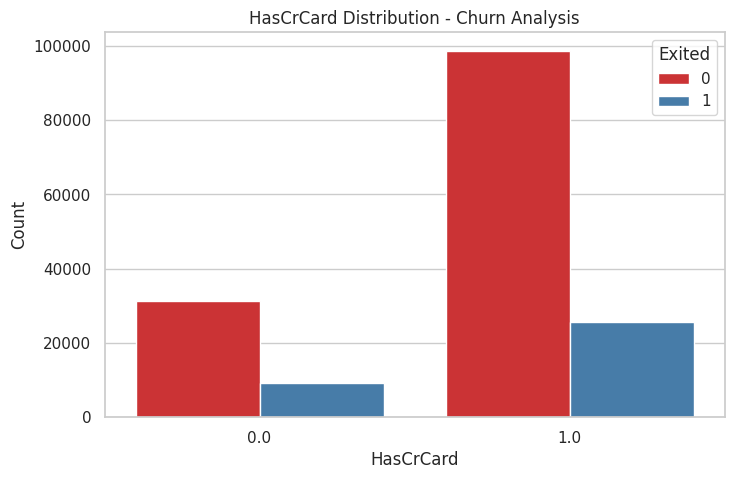

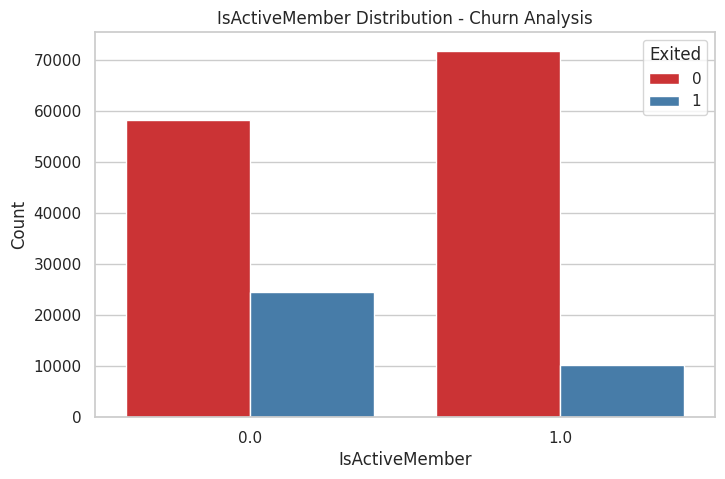

In [8]:
sns.set(style="whitegrid")

numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
categorical_features = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']

for feature in numerical_features:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Exited', y=feature, data=train)
    plt.title(f'{feature} Distribution - Churn Analysis')
    plt.show()

for feature in categorical_features:
    plt.figure(figsize=(8, 5))
    sns.countplot(x=feature, hue='Exited', data=train, palette='Set1')
    plt.title(f'{feature} Distribution - Churn Analysis')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.show()

# Correlation Analysis

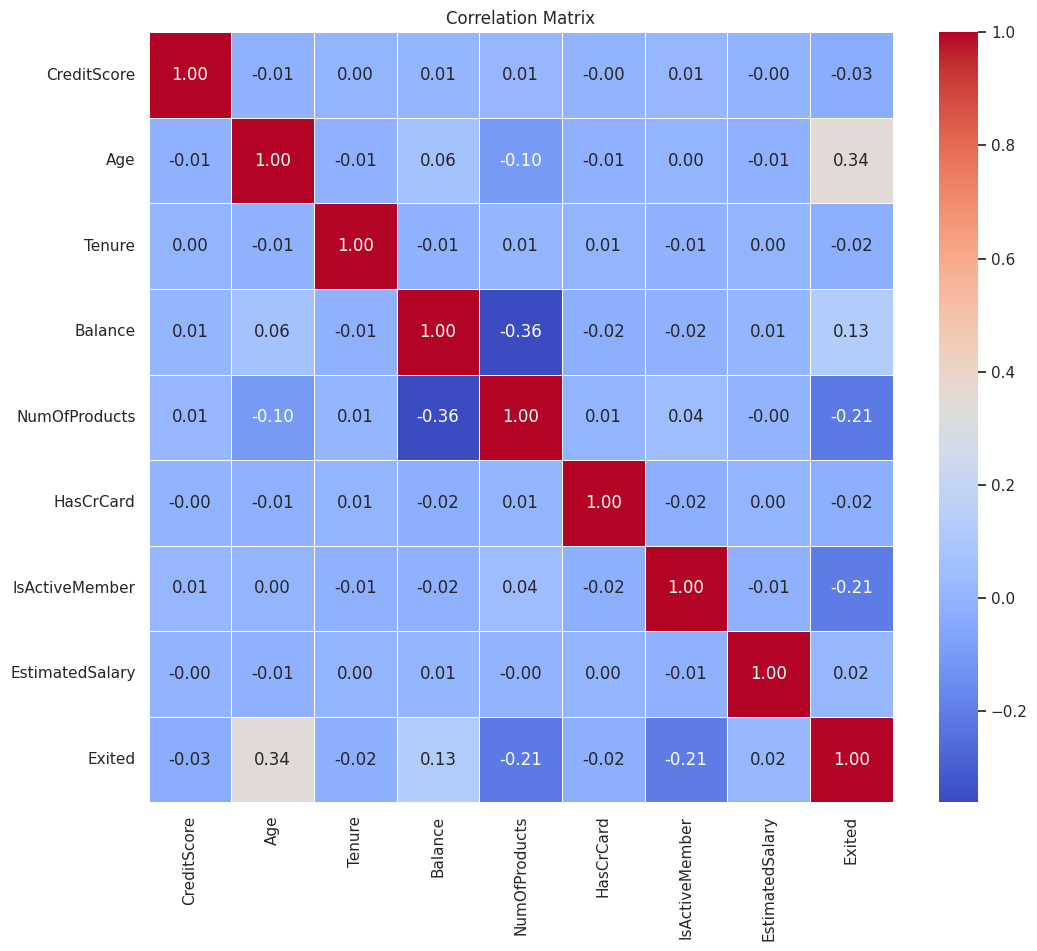

In [9]:
numerical_columns = train.select_dtypes(include=['float64', 'int64']).columns
df_numeric = train[numerical_columns]
correlation_matrix = df_numeric.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

# XGBoost Model

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}

Accuracy: 0.8682703668918714
Confusion Matrix:
 [[24779  1273]
 [ 3075  3880]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.95      0.92     26052
           1       0.75      0.56      0.64      6955

    accuracy                           0.87     33007
   macro avg       0.82      0.75      0.78     33007
weighted avg       0.86      0.87      0.86     33007



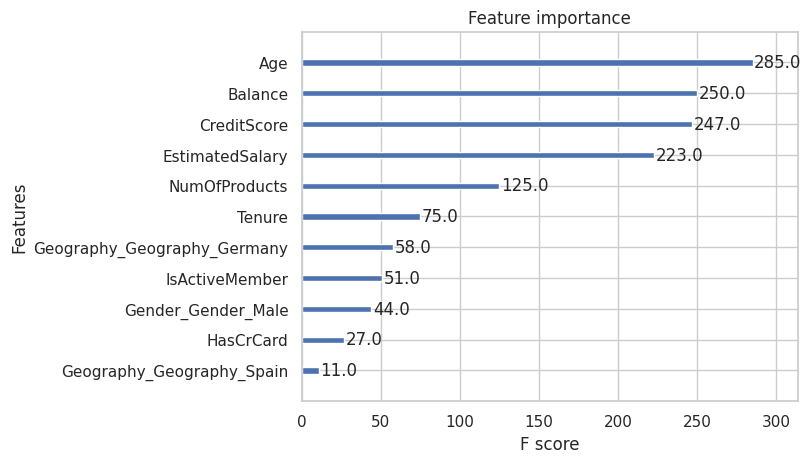

In [10]:
encoded_train = encode_categorical(train)
X = encoded_train.drop("Exited", axis=1)
y = encoded_train["Exited"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=3)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
xgb_model = xgb.XGBClassifier(**best_params, objective="binary:logistic", random_state=42)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Best Parameters:", best_params)
print(f"\nAccuracy: {accuracy}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_rep)

plot_importance(xgb_model)
plt.show()

In [11]:
# X = train.drop('Exited', axis=1)
# y = train['Exited']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
